## 모듈 불러오기

In [16]:
from array import array
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cv2
import matplotlib.pyplot as plt
import jenkspy

## IR, RGB 이미지 불러오기

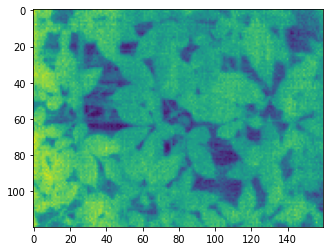

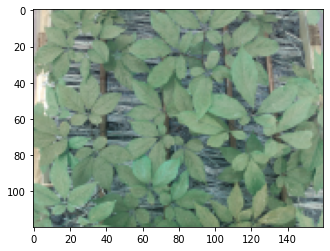

In [17]:
import util

ir_image = util.load_ir_in_dat('./ginseng-ir/irimage_20220728_0903.dat')
rgb_image = util.load_rgb_in_jpeg('./ginseng-rgb/1.jpeg')

util.show_ir(ir_image)
util.show_rgb(rgb_image)

# Excess-green(exg) 인덱스를 Jenks Natural Breaks로 클러스터링

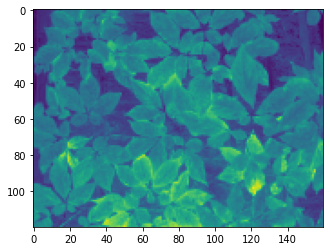

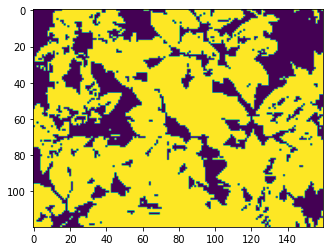

In [18]:
import util

exg = util.get_excess_green(rgb_image)
util.show_ir(exg)

label = util.predict_with_jenks(exg)
util.show_ir(label)

# IR 이미지를 클러스터링

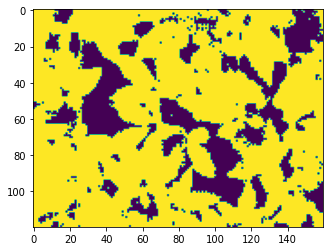

TP: 10693
FP: 3942
FN: 2600
TP: 10693
정확도:  0.6592708333333334
잎의 평균 온도: 24.44046258968256


In [19]:
from sklearn.metrics import confusion_matrix
import util

predict = util.predict_with_jenks(ir_image)
util.show_ir(predict)

tn, fp, fn, tp = confusion_matrix(y_true=label.ravel(),
                                  y_pred=predict.ravel()
                                  ).ravel()
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

print('정확도: ', (tp + tn)/(tp + tn + fp + fn))

average_temperature = util.get_average_temperature(ir_image, predict)
print(f'잎의 평균 온도: {average_temperature}')

In [24]:
import cv2

img = cv2.bitwise_and(cv2.cvtColor(ir_image, cv2.COLOR_GRAY2BGR),
                      rgb_image)

plt.imshow(img)
plt.show()

error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


3. Threshold 이진화

# main

In [ ]:
img = load_ir_image('./ginseng-ir/irimage_20220728_0903.dat')

hist, bin_edges = np.histogram(img, bins=256)
FREQUENCY = 500
indices = np.argwhere(hist > FREQUENCY)
start = bin_edges[indices[0, 0]]
end = bin_edges[indices[-1, 0] + 1]
bin_img = threshold(img, start, end)

# 열화상 이미지 출력
show_image(img, '열화상 이미지')

# 필터 영역 표시
show_image(bin_img, f'히스토그램 내 빈도수가 500 이상인 영역({start:.2f}~{end:.2f})')

# 히스토그램 출력
show_histogram(img)
print(f"잎의 평균 온도: {get_average_tempeature(img, bin_img):.2f}")

